In [154]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [2]:
price_trends = pd.read_csv('../data/train.csv')[['timestamp', 'price_doc']]
price_trends['timestamp'] = pd.to_datetime(price_trends['timestamp'])
price_trends = price_trends.set_index('timestamp')
price_trends = price_trends.resample('M').mean()
price_trends['color'] = 'historical'

In [3]:
predictions = pd.read_csv('../data/output/dist_dense_output.csv')
prediction_features = pd.read_csv('../data/test.csv')
pred_trends = predictions.set_index('id').join(prediction_features.set_index('id'))[['timestamp', 'price_doc']]
pred_trends['timestamp'] = pd.to_datetime(pred_trends['timestamp'])
pred_trends = pred_trends.set_index('timestamp')
pred_trends = pred_trends.resample('M').mean()
pred_trends['color'] = 'forecast'

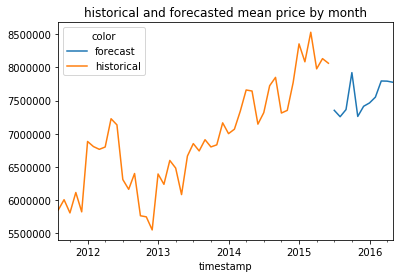

In [4]:
all_trends = price_trends.append(pred_trends)
all_trends.pivot(columns='color', values='price_doc').plot(title='historical and forecasted mean price by month')

In [178]:
def window_stack(a, step_size=1, width=3):
    """
    Returns sliding window of numpy matrix by <width> timesteps stacked
    e.g., for input matrix of (X, 33) with width 100
    returns (X-99, 100, 33)
    """
    return np.stack((a[i:1 + i - width or None:step_size] for i in range(0, width)),
                    axis=1)

macros = pd.read_csv('../data/macro.csv').fillna(method='ffill').fillna(method='bfill').iloc[:-1]
macros['timestamp'] = pd.to_datetime(macros['timestamp'])
macros = macros.set_index('timestamp')
monthly_means = macros.resample('M').mean().reset_index()
scaler = StandardScaler().fit(monthly_means.iloc[:, 1:])
# monthly_means.iloc[:, 1:] = scaler.transform(monthly_means.iloc[:, 1:])

lookback_months = 12
rolling_windows = window_stack(monthly_means, width=lookback_months)
num_months, _, num_features = rolling_windows.shape

flattened_df = pd.DataFrame(rolling_windows.reshape(num_months, -1))
flattened_df['timestamp'] = flattened_df.iloc[:, -1 * num_features]
all_dates_df = flattened_df.set_index('timestamp').asfreq('D', method='ffill')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [179]:
sample_date = all_dates_df.index.values[2050]
sample_data = pd.DataFrame(all_dates_df.iloc[2050].values.reshape(-1, num_features))
#sample_data.iloc[:, 1:] = scaler.inverse_transform(sample_data.iloc[:, 1:])
print(sample_date)
print(sample_data)

2016-08-11T00:00:00.000000000
           0        1        2    3      4      5        6       7     8   \
0  2015-08-31  45.5825  19284.1 -4.5  494.4  581.2  123.661  11.428  18.6   
1  2015-09-30  47.0118  19284.1 -4.5  496.1  581.9  123.661   9.838  18.6   
2  2015-10-31  47.3436  21294.4 -3.7    499  575.5  123.661  10.501  -3.4   
3  2015-11-30  42.3962  21294.4 -3.7  502.7  585.5  123.661  11.246  -3.4   
4  2015-12-31  36.7805  21294.4 -3.7  506.4  581.6  123.661  10.108  -3.4   
5  2016-01-31  29.1125  22016.1 -3.8  510.3  568.7   133.16  12.663   9.4   
6  2016-02-29  30.5943  22016.1 -3.8  515.2  560.8   133.16   8.481   9.4   
7  2016-03-31  36.6171  22016.1 -3.8  518.5  551.9   133.16   7.991   9.4   
8  2016-04-30  39.9762  18561.3 -1.2  520.9  569.1   133.16   8.721     8   
9  2016-05-31  45.0185  18561.3 -1.2  523.2    584   133.16   7.439     8   
10 2016-06-30  46.6518  18561.3 -1.2  525.3  589.6   133.16   8.421     8   
11 2016-07-31  43.6614  19979.4 -0.6  527.2  6

In [186]:
print(pd.DataFrame(all_dates_df.loc['2015-09-16'].values.reshape(-1, num_features)))

           0        1        2    3      4      5        6       7     8   \
0  2014-09-30  95.6732  18884.6  0.7  428.6  514.7  113.465  18.076  21.5   
1  2014-10-31  86.6257  20406.9  0.9  431.4  510.8  113.465  14.256   7.2   
2  2014-11-30  78.9665  20406.9  0.9  434.9  512.5  113.465   16.54   7.2   
3  2014-12-31  61.2833  20406.9  0.9  440.5  510.1  113.465  15.317   7.2   
4  2015-01-31  46.3414  21514.7  0.4    452  513.9  123.661  15.183  75.8   
5  2015-02-28   57.863  21514.7  0.4  469.4  520.7  123.661  16.889  75.8   
6  2015-03-31  54.6423  21514.7  0.4  479.8  531.7  123.661  14.695  75.8   
7  2015-04-30  59.1295  18209.7 -2.8  485.6    561  123.661   16.65  32.9   
8  2015-05-31  63.3737  18209.7 -2.8  487.8  575.9  123.661  15.602  32.9   
9  2015-06-30  61.4105  18209.7 -2.8  489.5  568.9  123.661  16.416  32.9   
10 2015-07-31  55.8961  19284.1 -4.5  490.5  572.8  123.661  14.788  18.6   
11 2015-08-31  45.5825  19284.1 -4.5  494.4  581.2  123.661  11.428  18.6   